# Data Wrangling & Baseline Model
---

#### Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import nltk
from sklearn import *

In [2]:
import matplotlib.style as style 

style.use('seaborn-darkgrid')
sns.set_context('notebook')
sns.set_palette('gist_heat')

## Wrangling

In [3]:
os.listdir('./csv_folder')

['sales_train.csv',
 'shops.csv',
 'test.csv',
 'item_categories.csv',
 '.ipynb_checkpoints',
 'items.csv']

- We will need to join the ***items*** and the ***sales_train*** dataframes
- The ***shops*** and ***item_categories*** only contain the names of id values
- The final file ***test*** will be used when submitting predictions

In [166]:
shops = pd.read_csv('./csv_folder/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


The names of the shops are in russian, should find some encoding that is capable of handling these

In [192]:
item_categs = pd.read_csv('./csv_folder/item_categories.csv')
item_categs.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


As shown above, the ***shops*** and ***item_categories*** only contain the names of id values. These may be useful later but for now we will use only the id values.

In [193]:
test = pd.read_csv('./csv_folder/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Showing the ***test*** data for reference

---
---  
### Understanding the sales_train data
---

In [178]:
train_df = pd.read_csv('./csv_folder/sales_train.csv')

In [179]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Lets break the date column into month and year, later we will aggregate item sales counts from days to months

In [180]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [181]:
train_df['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

***date_block_num***: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

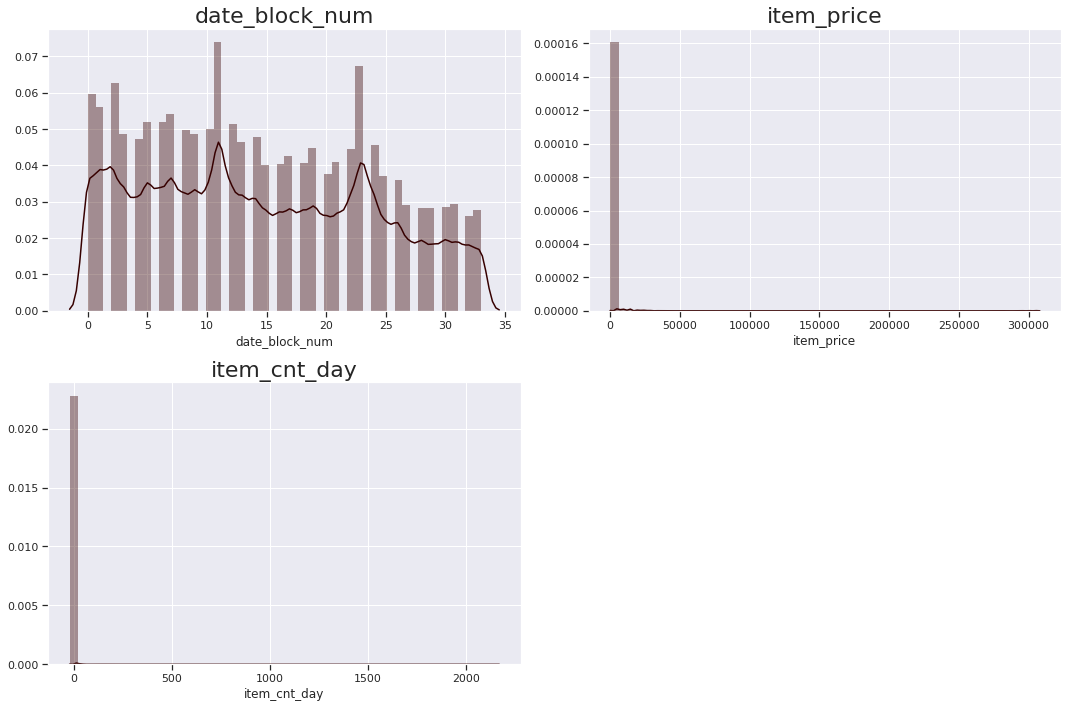

In [184]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.distplot(train_df['date_block_num'], ax=axes[0,0]).set_title('date_block_num', size=22)

sns.distplot(train_df['item_price'], ax=axes[0,1]).set_title('item_price', size=22)

sns.distplot(train_df['item_cnt_day'], ax=axes[1,0], kde_kws={'bw': 0.1}).set_title('item_cnt_day', size=22)

axes[1,1].set_visible(False)

plt.tight_layout()

In [185]:
train_df['item_cnt_day'].nunique()

198

In [186]:
train_df.index.nunique()

2935849

In [187]:
train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Dataframe contains no missing values

---
---  
### Understanding the items data
---

In [188]:
items = pd.read_csv('./csv_folder/items.csv')

In [189]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [190]:
items['item_category_id'].nunique()

84

There are 84 different categories for items

In [191]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

Dataframe contains no missing values

---
---  
### ????? Merging the sales train data frame with the items data 
---

***A pivot table to give a better visual understanding of the data***

In [195]:
train_df.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum').head()

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

---  
***Agregating sales counts by month per store per item***  

In [67]:
train_df.drop(['item_price'], axis=1, inplace=True)

In [69]:
train_df['date'] = pd.to_datetime(train_df['date'], dayfirst=True)
train_df['year'] = train_df.date.dt.year
train_df['month'] = train_df.date.dt.month

key_df = train_df[['date_block_num', 'year', 'month']].groupby(['date_block_num', 'year', 'month']).count().reset_index().set_index(['year', 'month'])
key_df.sort_values('date_block_num', ascending=True, inplace=True)

Making a key to recover the date block number because the next step will remove this column 

In [ ]:
####
# Writing to file for recovery to allow of a mid-notebook boot (incase there is insufficient ram)
####
# key_df.to_csv('wrangled_data/key_dateblock.csv', index=True)

In [68]:
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

train_df = pd.DataFrame(train_df.groupby(['shop_id', 'item_id', 'year', 'month'])['item_cnt_month'].sum()).reset_index()

Aggregating the item sales count into months since that is the figure we are being asked to predict

In [72]:
train_df.head(2)

,shop_id,item_id,year,month,item_cnt_month
0,0,30,2013,2,31.0
1,0,31,2013,2,11.0
2,0,32,2013,1,6.0
3,0,32,2013,2,10.0
4,0,33,2013,1,3.0


---  
***Fill missing rows***  
Creating rows for items that have zero count sales at a store for a given month

In [54]:
shop_items = train_df[['shop_id', 'item_id']].values
year = train_df.year.unique()
month = train_df.month.unique()
dates = [(y, m) for y in year for m in month]

index = pd.DataFrame([(d[0], d[1], k[0], k[1]) for d in dates for k in shop_items], 
                     columns=['year', 'month', 'shop_id', 'item_id'])

In [73]:
index.sort_values(by=['shop_id', 'item_id', 'year', 'month']).head()

,year,month,shop_id,item_id
1609124,2013,1,0,30
0,2013,2,0,30
4827372,2013,3,0,30
6436496,2013,4,0,30
8045620,2013,5,0,30


In [74]:
# train_df['date'] = pd.to_datetime(train_df[['year', 'month']].assign(DAY=1))
train_df = pd.merge(index, train_df, 
                    how='outer', 
                    on=['shop_id', 'item_id', 'year', 'month'])

In [84]:
del index

In [77]:
train_df.drop_duplicates(inplace=True)

In [79]:
train_df.isna().sum()

year                     0
month                    0
shop_id                  0
item_id                  0
item_cnt_month    13659340
dtype: int64

In [80]:
train_df['item_cnt_month'].fillna(0, inplace=True)

In [81]:
train_df.isna().sum()

year              0
month             0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

---  
---  

In [108]:
tmp = pd.DataFrame(train_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(lambda c: c.abs().sum()))

In [111]:
train_df.set_index(['shop_id', 'item_id'], inplace=True)

In [114]:
train_df = train_df.loc[tmp[tmp['item_cnt_month'] != 0].index]
del tmp

In [116]:
train_df.reset_index(inplace=True)

---  
---  

In [160]:
train_df = pd.merge(train_df, key_df, how='left', on=['year', 'month'])

In [162]:
train_df = train_df[~train_df['date_block_num'].isna()]

### Some Feature Engineering
---  

In [21]:
# train_df = pd.merge(train_df, items.drop(columns=['item_name']), how='left', on='item_id')

***Mean & Mode feature for items per store***

In [267]:
# Find mean sales for item at a store
agg_shop_item = pd.DataFrame(train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False).agg([np.mean, pd.Series.mode]))
agg_shop_item.columns = agg_shop_item.columns.droplevel()
agg_shop_item = agg_shop_item.rename(columns={'mean':'mean_item', 'mode':'mode_item'})

# Add mode to training set
train_df = pd.merge(train_df, agg_shop_item, how='left', on=['shop_id','item_id'])
del agg_shop_item

Creating a feature for the mean of item sales count of each month 

---  
---  
#### Load from saved csv

In [266]:
# key_df = pd.read_csv('wrangled_data/key_dateblock.csv')

####
# Writing to file for recovery to allow of a mid-notebook boot (incase there is insufficient ram)
####
# train_df.to_csv('wrangled_data/train_compress_index.csv', index=False)

# train_df = pd.read_csv('wrangled_data/train_compress_index.csv')

---  

In [ ]:
train_df['date'] = pd.to_datetime(train_df[['year', 'month']].assign(DAY=1)).apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
# Add last month
shop_prev_month = train_df[train_df['date_block_num']==33][['shop_id', 'item_id', 'item_cnt_month']]
shop_prev_month = shop_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})

Adding sales count for the prior month

In [ ]:
shop_prev_month.head()

In [ ]:
# Add previous month feature to training set
train_df = pd.merge(train_df, shop_prev_month, how='left', on=['shop_id', 'item_id']).fillna(0.)

Adding the feature we just made to the training set

In [ ]:
train_df.head()

In [ ]:
# Add all item features
train_df = pd.merge(train_df, items.drop(columns=['item_category_id']), how='left', on='item_id')

Merging the items dataframe into the our current training dataframe 

In [ ]:
# Adding item category features
train_df = pd.merge(train_df, item_categs, how='left', on='item_category_id')

Merging the item cetegory dataframe into the our current training dataframe 

In [ ]:
# Adding shop feature
train_df = pd.merge(train_df, shops, how='left', on='shop_id')

Merging the shops dataframe into the our current training dataframe 

In [ ]:
train_df.head()

The resulting training data after the merge

In [ ]:
test['month']=11
test['year']=2015
test['date_block_num']=34

Adding the prediction value to testing data

In [ ]:
# Adding mean feature
test = pd.merge(test, shop_item_mean, how='left', on=['shop_id', 'item_id']).fillna(0.)
# Adding previous month feature
test = pd.merge(test, shop_prev_month, how='left', on=['shop_id', 'item_id']).fillna(0.)
# Add all item features
test = pd.merge(test, items, how='left', on='item_id')
# Adding item category features
test = pd.merge(test, item_categs, how='left', on='item_category_id')
# Adding shop feature
test = pd.merge(test, shops, how='left', on='shop_id')

Takes the same features we created for the training data and adds them to our teting data

In [ ]:
test['item_cnt_month']=0.

---  
***Some label encoding for the names of items***  
May want to write csv before this and do further encoding in the preprocessing notebook  

In [ ]:
# Label encoding
for c in ['shop_name', 'item_name', 'item_category_name']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[c].unique())+list(test[c].unique()))
    train_df[c]=lbl.transform(train_df[c].astype(str))
    test[c]=lbl.transform(test[c].astype(str))
    print(c)

---  
---  
### Building a baseline model using Extra Trees Regressor from sci-kit learn

In [ ]:
# Train and predict using random forest 
col = [c for c in train_df.columns if c not in ['item_cnt_month']]
x1 = train_df[train_df['date_block_num']<33]
y1 = np.log1p(x1['item_cnt_month'].clip(0.,20.))
x1 = x1[col]
x2 = train_df[train_df['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0, 20.))
x2 = x2[col]

Creating a method to test our model without having to submit by using the most resent month as a hypothetical future month and then using the values of that month to validate the effectivness of the model

In [ ]:
reg = ensemble.ExtraTreesRegressor(n_estimators=30, n_jobs=-1, max_depth=20, random_state=18)
reg.fit(x1,y1)
print('RMSE value is :', np.sqrt(metrics.mean_squared_error(y2.clip(0., 20.), reg.predict(x2).clip(0., 20.))))

Since the competition grades models based upon the RMSE metric we will use that to evaluate our model so that we are optimizing in that direction

In [ ]:
reg.fit(train_df[col], train_df['item_cnt_month'].clip(0., 20.))
test['item_cnt_month'] = reg.predict(test[col]).clip(0., 20.)

In [ ]:
test[['ID', 'item_cnt_month']].to_csv('submission_files/submit.csv', index=False)

Writing the predictions to a csv file

---  
***Writing training and testing data into csv files***

In [ ]:
test.drop(columns=['item_cnt_month']).to_csv('wrangled_data/testing_dataframe.csv', index=False)
train_df.to_csv('wrangled_data/training_dataframe.csv', index=False)